### Imports

In [61]:
import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [62]:
### Download and read csv

In [63]:
url = "https://drive.google.com/u/0/uc?id=1VUn2WKkKeRXwH02K9bqH98KjPxrUmgXh&export=download"
filename = "HousingData.csv"
gdown.download(url, filename, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1VUn2WKkKeRXwH02K9bqH98KjPxrUmgXh&export=download
To: /content/HousingData.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 133MB/s]


'HousingData.csv'

In [64]:
data = pd.read_csv("HousingData.csv")

### Remove empty entries

In [65]:
data.dropna(inplace = True)

### Prepare X and y
- y is Median House Value
- X is all the other columns

In [66]:
y = data[['Median House Value']]
X = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]

### Feature Scaling
Convert X data in order to make the numerical attributes have the similar scales

In [67]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

### Stochastic Gradient Descent

In [69]:
reg =  SGDRegressor(loss='huber', max_iter=1000)

### Cross Validation Score

In [70]:
%%time

score = cross_val_score(reg , X_train, y_train, scoring = "neg_mean_squared_error", cv = 10, n_jobs=4)

CPU times: user 56.2 ms, sys: 8.89 ms, total: 65.1 ms
Wall time: 217 ms


In [71]:
tree_rmse_scores = np.sqrt(-score)
tree_rmse_scores.mean()

0.7677973900357236

 Πραγματοποιείται training για 20 βήματα στην αρχη και μετά αυξάνονται τα βήματα ανά 20 μέχρι να φτάσουμε στα 200 και κάνουμε plot τα Mean Squared Error για τα test data και τα train data. Παρατηρούμε, πως η απόδοση δεν αλλάζει προσθέτοντας instances.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

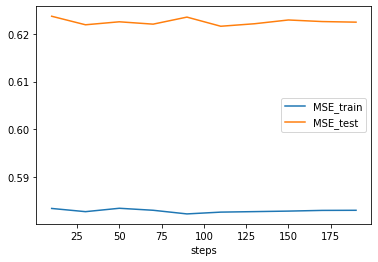

In [72]:
MSE_test = []
MSE_train = []
for steps_num in range(0,1000,20):
    
    reg =  SGDRegressor(loss='huber', max_iter=1000)
    reg.fit(X_train, y_train)
    MSE_test.append(mean_squared_error(y_test, reg.predict(X_test)))
    MSE_train.append(mean_squared_error(y_train, reg.predict(X_train))) 
    

plot_data = {
    'steps': list(range(10,200,20)),
    'MSE_train' : MSE_train,
    'MSE_test' : MSE_test
}
df = pd.DataFrame(plot_data, columns = ['steps', 'MSE_train', 'MSE_test'])
df.plot(x="steps")

In [73]:
r2_score(y_test, y_pred)

0.5870693178443457

### Batch Gradient Descent

Αλλάζοντας το **learning rate** σε 0,01 δίνει λίγο καλύτερα **r2 score** (περίπου 0,53 με learning_rate=0.1, 0,59 με learning_rate=0.01)  



In [74]:
# function to compute predictions created for the current dataset
# where y = w0 + w1*x1 +...+w8*x8 
def predict(X, theta):
  return np.dot(X, theta[0:8]) + theta[8]
  
# function to compute gradient of error 
def gradient(X, y, theta): 
    h = np.dot(X, theta) 
    grad = (2/X.shape[0])*np.dot(X.transpose(), (h - y)) 
    return grad 
  
# function to compute MSE
def cost(X, y, theta): 
    h = np.dot(X, theta) 
    J = np.dot((h - y).transpose(), (h - y)) 
    J /= X.shape[0]
    return J[0] 
  
# function to perform mini-batch gradient descent
def gradientDescent(X, y, learning_rate = 0.1, steps=1000): 
    X = np.c_[ X, np.ones(X.shape[0]) ] #add a column of ones to X for the bias term
    theta = np.zeros((X.shape[1], 1)) #create inital weights w0, w1..wd
    error_list = []  
    for s in range(steps):
      theta = theta - learning_rate * gradient(X, y, theta) 
      error_list.append(cost(X, y, theta)) #useful for plotting changes when using different batch sizes
  
    return theta, error_list 

theta, errors = gradientDescent(X_train, y_train, 0.01)
y_pred = predict(X_test, theta)

To **Batch Gradient Descent** παρaτηρούμε πως δίνει καλύτερα score από το **Stochastic Gradient Descent** 

In [75]:
r2_score(y_test,y_pred)

0.5870693178443457

Από το παρακάτω διάγραμμα παρατηρούμε πως το Mean Squared Error μειώνεται για τα πρώτα 100 steps περίπου, αλλά μετα δεν υπάρχει κάποια ιδιαίτερη βελτίωση. 

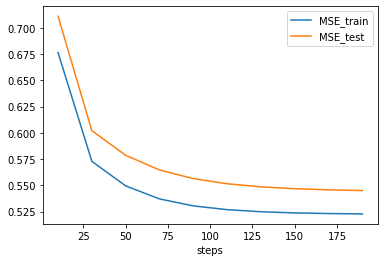

In [76]:
MSE_test = []
MSE_train = []
for steps_num in range(10,200,20):
    theta, errors = gradientDescent(X_train, y_train, steps=steps_num)
    
    
    MSE_test.append(mean_squared_error(y_test, predict(X_test, theta)))
    MSE_train.append(mean_squared_error(y_train, predict(X_train, theta))) 
    

plot_data = {
    'steps': list(range(10,200,20)),
    'MSE_train' : MSE_train,
    'MSE_test' : MSE_test
}
df = pd.DataFrame(plot_data, columns = ['steps', 'MSE_train', 'MSE_test'])
df.plot(x="steps")

### Mini Batch Gradient Descent

Πρόσθεσα τη συνάρτηση **create_mini_batches** που δημιουργεί κάθε φορά μία λίστα με mini batches για το training και άλλαξα το learning rate κι εδώ σε 0.01

Την create_mini_batches ν πήρα από το παρακάτω link:

https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/

In [77]:
# function to compute predictions created for the current dataset
# where y = w0 + w1*x1 +...+w8*x8 
def predict(X, theta):
  return np.dot(X, theta[0:8]) + theta[8]
  
# function to compute gradient of error 
def gradient(X, y, theta): 
    h = np.dot(X, theta) 
    grad = (2/X.shape[0])*np.dot(X.transpose(), (h - y)) 
    return grad 
  
# function to compute MSE
def cost(X, y, theta): 
    h = np.dot(X, theta) 
    J = np.dot((h - y).transpose(), (h - y)) 
    J /= X.shape[0]
    return J[0] 
 
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
  
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches    
  
# function to perform mini-batch gradient descent
def gradientDescent(X, y, learning_rate = 0.01, steps=1000, mini_batch_size=500): 
    X = np.c_[ X, np.ones(X.shape[0]) ] #add a column of ones to X for the bias term
    theta = np.zeros((X.shape[1], 1)) #create inital weights w0, w1..wd
    error_list = [] 
    counter = 1 
    for s in range(steps):
      mini_batch_error_list = []
      mini_batches = create_mini_batches(X, y, mini_batch_size)
      for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        theta = theta - learning_rate * gradient(X_mini, y_mini, theta) 
        mini_batch_error_list.append(cost(X_mini, y_mini, theta)) #useful for plotting changes when using different batch sizes
      counter+=1
      error_list.append(sum(mini_batch_error_list) / len(mini_batch_error_list) )
    return theta, error_list 

Στο παρακάτω σχεδιάγραμμα παρατηρούμε, πως πάλι το error μειώνεται δραστικά αλλά στα 50 περίπου βήματα σταματάμε να έχουμε κάποια ιδιαίτερη βελτίωση.
Βλέπουμε, πως στο mini batch gradient descent τα φτάνουμε πιο γρήγορα στις καλύτερες τιμές του error απ ότι στο Batch Gradient Descent.

In [78]:
MSE_test = []
MSE_train = []
for steps_num in range(10,200,20):
    theta, errors = gradientDescent(X_train, y_train, steps=steps_num)
    
    
    MSE_test.append(mean_squared_error(y_test, predict(X_test, theta)))
    MSE_train.append(mean_squared_error(y_train, predict(X_train, theta))) 
    


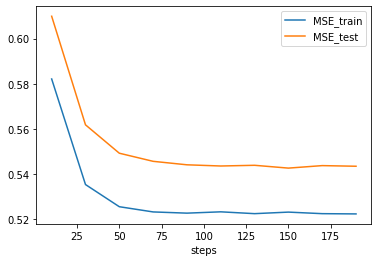

In [80]:
plot_data = {
    'steps': list(range(10,200,20)),
    'MSE_train' : MSE_train,
    'MSE_test' : MSE_test
}
df = pd.DataFrame(plot_data, columns = ['steps', 'MSE_train', 'MSE_test'])
df.plot(x="steps")

To Mini **Batch Gradient Descent** δίνει τα καλύτερα score από τις τρεις προσεγγίσεις (**Stochastic**, **Batch**, **Mini Batch**)

In [81]:
r2_score(y_test,y_pred)

0.5870693178443457